## MTurk I/O for Image Dataset

The query of interest is: **The outlined boxes depict a person riding a bike** 

Want to generate the input .csv file for MTurk and parse the output csv file for results. Using MTurkHelper from babble with adjustments for candidate type.

In [1]:
import numpy as np
%matplotlib inline

import os
import sys
import pandas as pd


%load_ext autoreload
%autoreload 2

## MTurk Helper for Input CSV

In [2]:
sys.path.append('../data/')
from tutorials.babble import MTurkHelper
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


We want to make "fake" candidates for the visual tesk since it doesn't fit into the actual sense of the word "candidate". They will just be a list of image names that are saved (how convenient!)

In [3]:
filelist= [file for file in os.listdir('/dfs/scratch0/paroma/visual_genome/') if ((file.startswith('val_')) and (file.endswith('.png')))]
print (len(filelist) % 4 == 0)
print len(filelist)/4

False
259


In [4]:
helper = MTurkHelper(candidates=filelist, labels=[], num_hits=len(filelist)/4)

In [5]:
input_csv_path = './Labels_for_Visual_Genome_v0.2.csv'
helper.preprocess_visual(input_csv_path)

Wrote 259 HITs with 4 candidates per HIT


## MTurk Helper for Output Labels CSV

In [14]:
output_csv_path = (os.environ['SNORKELHOME'] + '/tutorials/babble/bike/data/Labels_for_Visual_Genome_all_out.csv')

Num HITs unique: 495
Num HITs total: 997


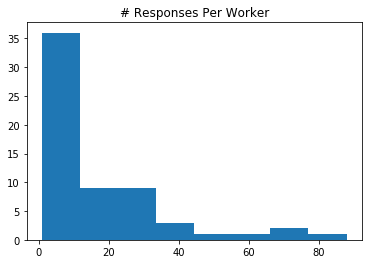

Median # seconds/HIT: 374 (93.0 s/explanation)


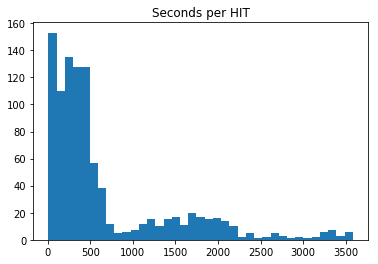

NameError: global name 'num_expected_explanations' is not defined

In [15]:
helper = MTurkHelper(candidates=[], labels=[], num_hits=259, domain='vg', workers_per_hit=2)
labels_by_candidate = helper.postprocess_labels(output_csv_path, candidates=[], verbose=True)

In [8]:
print "Number of Valid Dev Set Candidates: ", len(labels_by_candidate)
#np.save('/dfs/scratch0/paroma/coco/annotations/labels_by_candidate.npy', np.array(labels_by_candidate))

Number of Valid Dev Set Candidates:  906


## MTurk Helper for Explanations CSV

In [18]:
output_csv_path = (os.environ['SNORKELHOME'] + '/tutorials/babble/bike/data/VisualGenome_all_out.csv')

Num HITs unique: 40
Num HITs total: 120


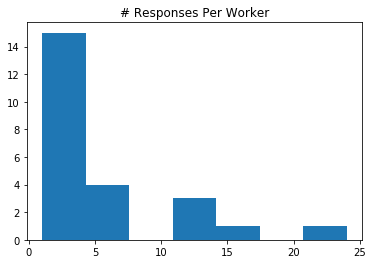

Median # seconds/HIT: 566 (141.0 s/explanation)


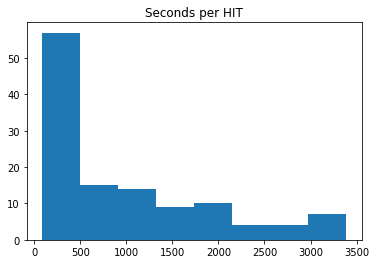

Unanimous: 99
Majority: 33
Bad: 27


In [19]:
helper = MTurkHelper(candidates=[], labels=[], num_hits=40, domain='vg', workers_per_hit=3)
explanations = helper.postprocess_visual(output_csv_path, candidates=[], verbose=True)

## Generating Train Candidates for Labels

In [6]:
all_train_cand = [file for file in os.listdir('/dfs/scratch0/paroma/visual_genome/') 
                  if ((file.startswith('train_')) and (file.endswith('.png')))]
print 'Num HITs: ', int(round(len(all_train_cand)/4.0))

Num HITs:  602


In [39]:
helper = MTurkHelper(candidates=all_train_cand, labels=[], num_hits=int(round(len(all_train_cand)/4.0)))

In [42]:
input_csv_path = './Train_Labels_for_Visual_Genome_in.csv'
helper.preprocess_visual(input_csv_path)

Wrote 602 HITs with 4 candidates per HIT


In [22]:
output_csv_path = (os.environ['SNORKELHOME'] + 'tutorials/babble/bike/data/Train_Labels_for_Visual_Genome_out.csv')

Analyzing train Set!
Num HITs unique: 602
Num HITs total: 1806


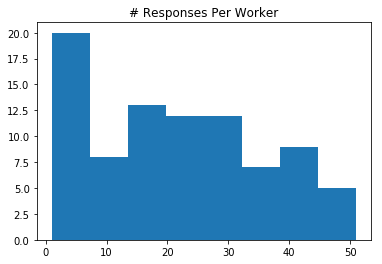

Median # seconds/HIT: 299 (74.0 s/explanation)


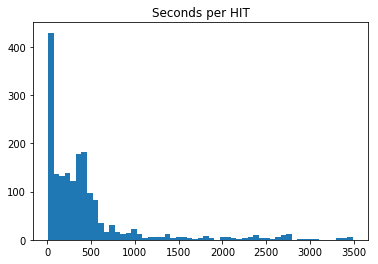

Unanimous: 1661
Majority: 441
Bad: 304


In [23]:
helper = MTurkHelper(candidates=[], labels=[], num_hits=int(round(len(all_train_cand)/4.0)), domain='vg', workers_per_hit=3)
labels_by_candidate = helper.postprocess_labels(output_csv_path, set_name='train', verbose=True)

In [24]:
print "Number of Valid Train Set Candidates: ", len(labels_by_candidate)
np.save('/dfs/scratch0/paroma/coco/annotations/train_labels_by_candidate.npy', np.array(labels_by_candidate))

Number of Valid Train Set Candidates:  2102


## Debugging for BabbleModel

In [20]:
from snorkel.contrib.babble import Babbler
user_lists = {}
babbler = Babbler(mode='image', explanations=explanations)

Created grammar with 418 rules


In [21]:
lfs = babbler.generate_lfs()
babbler.get_explanations()

338 parses created from 246 out of 367 explanation(s)


[Explanation("Explanation0: False, Box X barely overlaps Box Y."),
 Explanation("Explanation102: False, Box X is much wider than Box Y."),
 Explanation("Explanation104: False, Box X is much larger than Box Y."),
 Explanation("Explanation107: False, The lower edge of Box X is below than the lower edge of box Y."),
 Explanation("Explanation11: False, Box X is a lot smaller than Box Y."),
 Explanation("Explanation110: True, Box X overlaps the center of Box Y."),
 Explanation("Explanation111: True, Box Y is almost the same size as Box X."),
 Explanation("Explanation112: True, The bottom of box X is half covered by box Y"),
 Explanation("Explanation113: False, Box X is much wider than Box Y."),
 Explanation("Explanation114: False, Box X is 20 times as long as box Y"),
 Explanation("Explanation115: True, Box X is centered and slightly above Box Y."),
 Explanation("Explanation116: True, The bottom edge of box Y is just a little bit below the bottom edge of box X."),
 Explanation("Explanation1

In [18]:
babbler.filter_duplicate_semantics()

Filtered to 83 LFs with duplicate semantics filter (0 filtered).


In [17]:
from snorkel.contrib.babble import sem_to_str

for parse in babbler.parses:
    print(sem_to_str(parse.semantics))

return 1 if call(('.within', ('.box', ('.int', 0))), ('.box', ('.int', 1))) else 0
return 1 if call(('.below', ('.box', ('.int', 0))), ('.box', ('.int', 1))) else 0
return 1 if call(('.overlaps', ('.box', ('.int', 1))), ('.box', ('.int', 0))) else 0
return 1 if call(('.above', ('.box', ('.int', 1))), ('.box', ('.int', 0))) else 0
return 1 if call(('.near', ('.box', ('.int', 1))), ('.box', ('.int', 0))) else 0
return -1 if call(('.below', ('.box', ('.int', 1))), ('.box', ('.int', 0))) else 0
return -1 if call(('.taller', ('.box', ('.int', 1))), ('.box', ('.int', 0))) else 0
return -1 if call(('.smaller', ('.box', ('.int', 1))), ('.box', ('.int', 0))) else 0
return -1 if call(('.larger', ('.box', ('.int', 0))), ('.box', ('.int', 1))) else 0
return -1 if call(('.near', ('.corner', ('.box', ('.int', 1)), ('.string', 'top'), ('.string', 'left'))), ('.edge', ('.box', ('.int', 1)), ('.string', 'bottom'))) else 0
return -1 if call(('.near', ('.corner', ('.box', ('.int', 1)), ('.string', 'top')